In [4]:
# conda environment (project)
# /home/student/.conda/envs/project/bin/python 
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os, gc
import torch

from transformers import set_seed
from datasets import load_dataset
from evaluate import *
from arc import ARCSolver

from datasets import Dataset
from utils import render_grid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# prepare the test dataset
data_path = "dataset"
dataset, task_list = load_data(data_path)
df = sample_data(dataset, task_list, n_row=10000) 
df.head(5) 

Imported 300 different tasks in the dataset.
# of samples in a task: min(82), Q1(1000), Q2(1000), Q3(1000), max(1000), mean(897.7)


,task,train,test_input,test_output,test
0,239be575,"[{'input': [[0, 0, 6, 6, 2, 0, 0], [2, 0, 6, 6...","[{'input': [[0, 5, 5, 3, 3, 3, 0], [0, 5, 5, 0...",[[[0]]],"[{'input': [[0, 5, 5, 3, 3, 3, 0], [0, 5, 5, 0..."
1,4258a5f9,"[{'input': [[3, 3, 3, 3], [3, 3, 3, 3], [3, 3,...","[{'input': [[6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 2...","[[[6, 6, 6, 1, 1, 1], [1, 1, 1, 1, 2, 1], [1, ...","[{'input': [[6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 2..."
2,1caeab9d,"[{'input': [[6, 6, 6, 6, 6, 6, 6], [6, 6, 8, 8...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4..."
3,623ea044,"[{'input': [[3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3...","[{'input': [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], ...","[[[6, 8, 6, 6, 6], [6, 6, 8, 6, 8], [6, 6, 6, ...","[{'input': [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], ..."
4,e9afcf9a,"[{'input': [[4, 4, 4, 4, 4], [6, 6, 6, 6, 6], ...","[{'input': [[5, 5, 5, 5, 5, 5, 5, 5, 5], [7, 7...","[[[5, 7, 5, 7, 5, 7, 5, 7, 5], [7, 0, 7, 0, 7,...","[{'input': [[5, 5, 5, 5, 5, 5, 5, 5, 5], [7, 7..."


In [6]:
# prepare samples for each task
task_samples = []
for t in range(300):
    df = sample_data(dataset, task_list, n_row=1000, indices=[t])
    task_samples.append(df)

In [ ]:
# Visualize a task (EDA)
task_idx = 39 # select which task you want to examine
n_sample = 1
for data in Dataset.from_pandas(task_samples[task_idx]).shuffle().select(range(n_sample)):
    for case in data['train']:
        print("==================================================")
        print("Example input")
        render_grid(case['input'])
        print("Example output")
        render_grid(case['output'])
    print("==================================================")
    print("Example test input")
    render_grid(data['test'][0]['input'])
    print("Example test output")
    render_grid(data['test'][0]['output'])
print("==================================================")

In [7]:
# load our model(arcsolver) instance
set_seed(1234567890)
token = os.environ.get("HF_TOKEN", None)
solver = ARCSolver(token=token) # default: finetuning-sample (given sample adapter)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
solver.prepare_train()
n_train = 500
train_dataset = Dataset.from_pandas(task_samples[task_idx]).shuffle(42).select(range(n_train))
solver.train(train_dataset)

NameError: name 'solver' is not defined

In [ ]:
n_eval = 10
eval_dataset = Dataset.from_pandas(task_samples[task_idx]).shuffle(42).select(range(n_train,n_train+n_eval))
solver.prepare_evaluation(select_adapter="20250527_100116") # make sure you set the right model

In [51]:
# evaluate our model (eval set)
scores = []
for eval_data in tqdm(eval_dataset):
    print("============================================")
    print("Test input")
    render_grid(eval_data["test"][0]['input'])

    print("Predict output")
    preds = solver.predict(eval_data)
    render_grid(preds)

    print("Test output")
    render_grid(eval_data["test"][0]['output'])
    print("============================================")
    if preds is None: s = 0
    else: s = check_match(preds, eval_data["test"][0]["output"])
    scores.append(s)

score = np.array(scores).mean() * 100
print(f"Evaluation scores: {score:.2f}", flush=True)
print("Evaluation Success")

  0%|          | 0/10 [00:00<?, ?it/s]

Test input


                      [1, 6, 6, 6, 6, 1, 1, 1, 1, 1]
                      [1, 6, 1, 1, 6, 1, 1, 1, 1, 1]
                      [1, 6, 1, 1, 6, 1, 1, 1, 1, 1]
                      [1, 6, 1, 1, 6, 1, 1, 1, 1, 1]
                      [1, 6, 6, 6, 6, 1, 1, 1, 1, 1]
                      [1, 1, 3, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 9, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 3, 3, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Predict output


            [6 6 6 6 1]
            [6 1 3 6 1]
            [6 1 9 6 1]
            [6 1 3 6 1]

Test output


          [6, 6, 6, 6]
          [6, 3, 1, 6]
          [6, 9, 1, 6]
          [6, 3, 3, 6]
          [6, 6, 6, 6]

Test input


                  [1, 1, 1, 1, 1, 1, 1, 1]
                  [9, 9, 9, 9, 1, 1, 1, 1]
                  [9, 1, 1, 9, 1, 1, 1, 1]
                  [9, 1, 1, 9, 1, 1, 1, 1]
                  [9, 9, 9, 9, 1, 1, 1, 1]
                  [1, 0, 1, 1, 1, 1, 1, 1]
                  [1, 8, 8, 1, 1, 1, 1, 1]

Predict output


          [9 9 9 9]
          [9 1 0 9]
          [9 1 8 9]
          [9 9 9 9]

Test output


          [9, 9, 9, 9]
          [9, 0, 1, 9]
          [9, 8, 8, 9]
          [9, 9, 9, 9]

Test input


                    [7, 7, 7, 7, 2, 3, 7, 7, 7]
                    [7, 7, 7, 7, 7, 3, 2, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 5, 5, 5, 5, 5, 7, 7]
                    [7, 7, 5, 7, 7, 7, 5, 7, 7]
                    [7, 7, 5, 7, 7, 7, 5, 7, 7]
                    [7, 7, 5, 5, 5, 5, 5, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]

Predict output


            [5 5 5 5 5]
            [5 2 3 7 5]
            [5 7 3 2 5]
            [5 5 5 5 5]

Test output


            [5, 5, 5, 5, 5]
            [5, 2, 3, 7, 5]
            [5, 7, 3, 2, 5]
            [5, 5, 5, 5, 5]

Test input


                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 4, 2, 2, 2, 2, 2, 2]
                    [2, 0, 8, 8, 2, 2, 2, 2, 2]
                    [2, 2, 8, 2, 5, 5, 5, 5, 5]
                    [2, 2, 2, 2, 5, 2, 2, 2, 5]
                    [2, 2, 2, 2, 5, 2, 2, 2, 5]
                    [2, 2, 2, 2, 5, 2, 2, 2, 5]
                    [2, 2, 2, 2, 5, 5, 5, 5, 5]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]

Predict output


            [5 5 5 5 5]
            [5 2 8 8 5]
            [5 2 8 0 5]
            [5 2 2 2 5]
            [5 5 5 5 5]
            [2 2 2 2 2]

Test output


            [5, 5, 5, 5, 5]
            [5, 2, 4, 2, 5]
            [5, 0, 8, 8, 5]
            [5, 2, 8, 2, 5]
            [5, 5, 5, 5, 5]

Test input


                    [5, 5, 5, 3, 3, 3, 3, 3, 5]
                    [5, 5, 5, 3, 5, 5, 5, 3, 5]
                    [5, 5, 5, 3, 5, 5, 5, 3, 5]
                    [5, 5, 5, 3, 5, 5, 5, 3, 5]
                    [5, 5, 5, 3, 3, 3, 3, 3, 5]
                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [8, 0, 2, 5, 5, 5, 5, 5, 5]
                    [6, 7, 5, 5, 5, 5, 5, 5, 5]
                    [9, 0, 5, 5, 5, 5, 5, 5, 5]

Predict output


            [3 3 3 3 3]
            [3 0 8 5 3]
            [3 5 6 7 3]
            [3 0 9 5 3]
            [3 3 3 3 3]
            [5 5 5 5 5]

Test output


            [3, 3, 3, 3, 3]
            [3, 8, 0, 2, 3]
            [3, 6, 7, 5, 3]
            [3, 9, 0, 5, 3]
            [3, 3, 3, 3, 3]

Test input


                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 7]
                      [2, 2, 2, 2, 2, 2, 2, 1, 0, 8]
                      [2, 2, 5, 5, 5, 5, 5, 2, 2, 2]
                      [2, 2, 5, 2, 2, 2, 5, 2, 2, 2]
                      [2, 2, 5, 2, 2, 2, 5, 2, 2, 2]
                      [2, 2, 5, 5, 5, 5, 5, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predict output


            [5 5 5 5 5]
            [5 2 2 7 5]
            [5 1 0 8 5]
            [5 5 5 5 5]

Test output


            [5, 5, 5, 5, 5]
            [5, 2, 2, 7, 5]
            [5, 1, 0, 8, 5]
            [5, 5, 5, 5, 5]

Test input


                [2, 2, 2, 2, 1, 2, 2]
                [2, 2, 2, 2, 4, 2, 2]
                [6, 6, 6, 6, 2, 4, 2]
                [6, 2, 2, 6, 2, 1, 2]
                [6, 2, 2, 6, 2, 2, 2]
                [6, 2, 2, 6, 2, 2, 2]
                [6, 2, 2, 6, 2, 2, 2]
                [6, 6, 6, 6, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]

Predict output


          [6 6 6 6]
          [6 2 1 6]
          [6 2 4 6]
          [6 2 2 6]
          [6 2 2 6]
          [6 6 6 6]

Test output


          [6, 6, 6, 6]
          [6, 1, 2, 6]
          [6, 4, 2, 6]
          [6, 2, 4, 6]
          [6, 2, 1, 6]
          [6, 6, 6, 6]

Test input


                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 8, 2]
                      [2, 2, 2, 2, 2, 2, 2, 8, 8, 8]
                      [2, 2, 7, 7, 7, 7, 7, 2, 8, 8]
                      [2, 2, 7, 2, 2, 2, 7, 2, 2, 2]
                      [2, 2, 7, 2, 2, 2, 7, 2, 2, 2]
                      [2, 2, 7, 2, 2, 2, 7, 2, 2, 2]
                      [2, 2, 7, 7, 7, 7, 7, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predict output


            [7 7 7 7 7]
            [7 8 2 2 7]
            [7 2 8 8 8]
            [7 8 2 2 8]

Test output


            [7, 7, 7, 7, 7]
            [7, 2, 8, 2, 7]
            [7, 8, 8, 8, 7]
            [7, 2, 8, 8, 7]
            [7, 7, 7, 7, 7]

Test input


                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
                      [8, 8, 8, 5, 5, 5, 5, 5, 8, 8]
                      [8, 8, 8, 5, 8, 8, 8, 5, 8, 8]
                      [8, 8, 8, 5, 8, 8, 8, 5, 8, 8]
                      [8, 8, 8, 5, 8, 8, 8, 5, 8, 8]
                      [8, 8, 8, 5, 5, 5, 5, 5, 8, 8]
                      [8, 8, 8, 2, 6, 8, 8, 8, 8, 8]
                      [8, 8, 9, 6, 1, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 1, 8, 8, 8, 8, 8]

Predict output


            [5 5 5 5 5]
            [9 6 1 8 5]
            [6 8 1 8 5]
            [5 8 8 8 5]
            [5 5 5 5 5]

Test output


            [5, 5, 5, 5, 5]
            [5, 8, 2, 6, 5]
            [5, 9, 6, 1, 5]
            [5, 8, 8, 1, 5]
            [5, 5, 5, 5, 5]

Test input


                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [7, 7, 7, 7, 7, 5, 5, 5, 8]
                    [7, 5, 5, 5, 7, 5, 5, 2, 9]
                    [7, 5, 5, 5, 7, 5, 0, 5, 5]
                    [7, 5, 5, 5, 7, 5, 5, 5, 5]
                    [7, 7, 7, 7, 7, 5, 5, 5, 5]

Predict output


            [7 7 7 7 7]
            [7 5 5 2 8]
            [7 5 0 5 9]
            [7 5 5 5 7]
            [7 7 7 7 7]

Test output


            [7, 7, 7, 7, 7]
            [7, 5, 5, 8, 7]
            [7, 5, 2, 9, 7]
            [7, 0, 5, 5, 7]
            [7, 7, 7, 7, 7]

Evaluation scores: 20.00
Evaluation Success


In [30]:
solver.prepare_train()
n_train = 10000
df20 = sample_data(dataset, task_list, n_row=10500, indices=list(range(20)))
train_dataset = Dataset.from_pandas(df20).select(range(n_train))
solver.train(train_dataset)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert for solving logical puzzles. You are given some pairs of input and output as coordinates of 2D grid with the same underlying spatial pattern between them. The grid is given as their width, height, and coordinates of pixels filled with each certain colors. You have to logically infer the exact rule that generates each output from the given input.

<|start_header_id|>user<|end_header_id|>
Here are some examples of input and corresponding output. Learn the rule of generating output from given input.
----------------------------------------
input:
width: 3
height: 5
black: [(0,0), (0,2), (4,2)]
output for the given input:
width: 3
height: 5
black: [(0,0), (0,2), (1,1), (2,0), (2,2), (3,1), (4,0), (4,2)]
purple: [(0,1), (1,0), (1,2), (2,1), (3,0), (3,2), (4,1)]

input:
width: 7
height: 10
white: [(0,6), (9,0), (9,6)]
output for the given input:
width: 7
height: 10
white: [(0,3), (0,6), (1,2), (1,4), (1,5), (2,1), 

/home/kkernell/.arcproj/lib/python3.12/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/kkernell/.arcproj/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


trainable params: 12,156,928 || all params: 3,224,906,752 || trainable%: 0.3770


Truncating train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,5.169900
20,0.085300
30,0.064500
40,0.053600
50,0.050000
60,0.049800
70,0.038700
80,0.037000
90,0.043800
100,0.038100


(10500, 5)

In [ ]:
n_eval = 20
solver.prepare_evaluation(select_adapter="20250527_011623") # make sure you set the right model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>


In [ ]:
# from safetensors import safe_open
# from safetensors.torch import save_file

# safetensors 파일 열기
# with safe_open("artifacts/20250527_011623/checkpoint-final/adapter_model.safetensors", framework="pt", device="cpu") as f:
#     for k in f.keys(): print(k)
#     state_dict = {k: f.get_tensor(k) for k in f.keys()}

# fixed_state_dict = {}
# for key in state_dict:
#     new_key = key.replace("base_model.model.base_model.model.model", "base_model.model.model")
#     fixed_state_dict[new_key] = state_dict[key]

# save_file(fixed_state_dict, "artifacts/20250527_011623/checkpoint-final/adapter_model_fixed.safetensors")

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 10.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 15.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 45.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 35.00


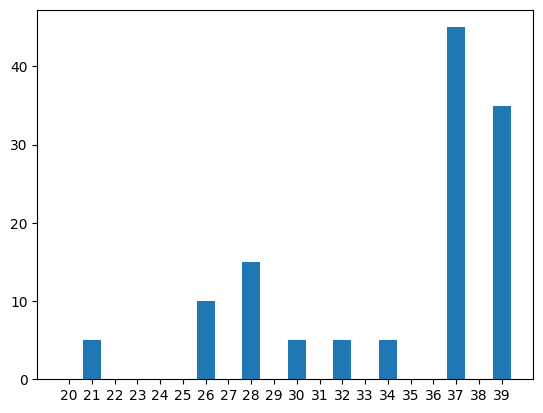

In [19]:
# evaluate our model (eval set)
scores = []
scores_task = []
for task in range(20,40):
    eval_dataset = Dataset.from_pandas(task_samples[task]).shuffle(42).select(range(n_eval))
    for eval_data in tqdm(eval_dataset):
        # print("============================================")
        # print("Test input")
        # render_grid(eval_data["test"][0]['input'])

        # print("Predict output")
        preds = solver.predict(eval_data)
        # render_grid(preds)

        # print("Test output")
        # render_grid(eval_data["test"][0]['output'])
        # print("============================================")
        if preds is None: s = 0
        else: s = check_match(preds, eval_data["test"][0]["output"])
        scores.append(s)
    score = np.array(scores).mean() * 100
    scores_task.append(score)
    print(f"Evaluation score: {score:.2f}", flush=True)
    scores = []

from matplotlib import pyplot as plt
x = np.arange(20,40)
plt.bar(x, scores_task)
plt.xticks(x, list(range(20,40)))
plt.show()